In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install micrograd

In [3]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [4]:
np.random.seed(1337)
random.seed(1337)

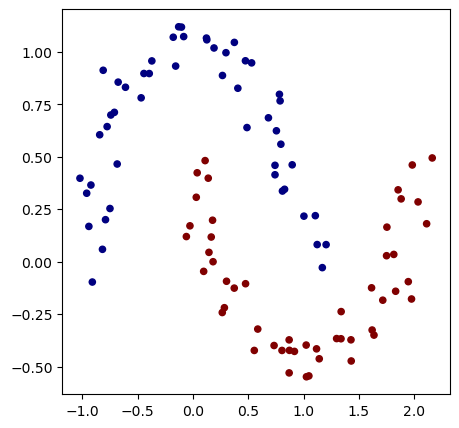

In [5]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1
plt.figure(figsize=(5,5))
plt.scatter(X[:,0],X[:,1],c=y,s=20,cmap='jet')

In [6]:
model = MLP(2,[16,16,1])
print(model.parameters())

[Value(data=0.23550571390294128, grad=0), Value(data=0.06653114721000164, grad=0), Value(data=0, grad=0), Value(data=-0.26830328150124894, grad=0), Value(data=0.1715747078045431, grad=0), Value(data=0, grad=0), Value(data=-0.6686254326224383, grad=0), Value(data=0.6487474938152629, grad=0), Value(data=0, grad=0), Value(data=-0.23259038277158273, grad=0), Value(data=0.5792256498313748, grad=0), Value(data=0, grad=0), Value(data=0.8434530197925192, grad=0), Value(data=-0.3847332240409951, grad=0), Value(data=0, grad=0), Value(data=0.9844941451716409, grad=0), Value(data=-0.5901079958448365, grad=0), Value(data=0, grad=0), Value(data=0.31255526637777775, grad=0), Value(data=0.8246106857787521, grad=0), Value(data=0, grad=0), Value(data=-0.7814232047574572, grad=0), Value(data=0.6408752595662697, grad=0), Value(data=0, grad=0), Value(data=-0.20252189189007108, grad=0), Value(data=-0.8693137391598071, grad=0), Value(data=0, grad=0), Value(data=0.39841666323128555, grad=0), Value(data=-0.303

In [7]:
print(np.random.permutation(X.shape[0])[:2])

[ 5 59]


define the loss fn:- batch_size; define X,y -> make a model and predict values -> calculate loss -> some L2 regularization -> accuracy -> return all (and yeah! convert to Values in b/w)

In [8]:
#karpathy code
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


In [9]:
loss(10)

(Value(data=0.8460186063112436, grad=0), 0.6)

In [10]:
check = list(p*p for p in model.parameters())
sum(check)

Value(data=95.92656431500008, grad=0)

In [11]:
for k in range(100):
    #forward pass
    total_loss,acc = loss()
    
    #backward
    model.zero_grad()
    total_loss.backward()
    
    #update
    learning_rate = 1-0.009*k
    for p in model.parameters():
        p.data -= p.grad*learning_rate
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.723590533697202, accuracy 81.0%
step 2 loss 0.7429006313851131, accuracy 77.0%
step 3 loss 0.7705641260584198, accuracy 82.0%
step 4 loss 0.3692793385976537, accuracy 84.0%
step 5 loss 0.313545481918522, accuracy 86.0%
step 6 loss 0.2814234349772435, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.2567147286057417, accuracy 91.0%
step 9 loss 0.27048625516379227, accuracy 91.0%
step 10 loss 0.24507023853658047, accuracy 91.0%
step 11 loss 0.25099055297915035, accuracy 92.0%
step 12 loss 0.2156095185192295, accuracy 91.0%
step 13 loss 0.23090378446402726, accuracy 93.0%
step 14 loss 0.2015215122789945, accuracy 92.0%
step 15 loss 0.22574506279282222, accuracy 93.0%
step 16 loss 0.1944798759620412, accuracy 92.0%
step 17 loss 0.21089496199246358, accuracy 93.0%
step 18 loss 0.15983077356303602, accuracy 94.0%
step 19 loss 0.18453748746883922, accuracy 93.0%
step 20 loss 0.1897752285608764, accuracy 9

(-1.548639298268643, 1.951360701731357)

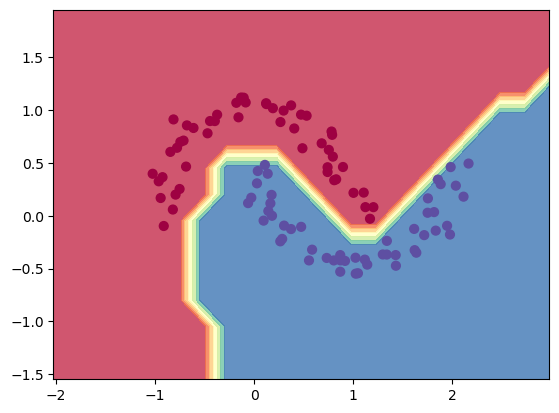

In [12]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())